In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
import math
import matplotlib.pyplot as plt
import random

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Ensure reproducibility in CuDNN backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [47]:
def load_datasets():
    train_path = 'loaded_data/a_patient_data_processed_cluster.parquet'
    val_path = 'loaded_data/b_patient_data_processed_cluster.parquet'
    test_path = 'loaded_data/c_patient_data_processed_cluster.parquet'
    train_df = pd.read_parquet(train_path)
    val_df = pd.read_parquet(val_path)
    test_df = pd.read_parquet(test_path)
    return train_df, val_df, test_df

train_df, val_df, test_df = load_datasets()

feature_columns = [col for col in train_df.columns if col not in ["RecordID", "In-hospital_death", "ICUType"]]

def pad_to_fixed_length(tensor, length=49):
    current_length = tensor.size(0)
    if current_length < length:
        padding = torch.zeros((length - current_length, tensor.size(1)))
        return torch.cat([tensor, padding], dim=0)
    else:
        return tensor
    
def process_dataframe(df, feature_columns, sequence_length=49):
    grouped = df.groupby("RecordID")
    list_of_patient_tensors = []
    labels = []

    for record_id, group in grouped:
        group_tensor = torch.tensor(group[feature_columns].values, dtype=torch.float32)
        group_tensor_fixed = pad_to_fixed_length(group_tensor, length=sequence_length)
        list_of_patient_tensors.append(group_tensor_fixed)
        labels.append(group["In-hospital_death"].max())  # label = 1 if death at any timestep

    sequences = torch.stack(list_of_patient_tensors)
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
    return sequences, labels





In [48]:
#Note that the labels are not used in the pretraining phase, but are used in the fine-tuning phase.
padded_sequences_train, labels_tensor_train = process_dataframe(train_df, feature_columns)
padded_sequences_val, labels_tensor_val = process_dataframe(val_df, feature_columns)
padded_sequences_test, labels_tensor_test = process_dataframe(test_df, feature_columns)

batch_size = 32
train_dataset = TensorDataset(padded_sequences_train, labels_tensor_train)
val_dataset = TensorDataset(padded_sequences_val, labels_tensor_val)
test_dataset = TensorDataset(padded_sequences_test, labels_tensor_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [49]:
#Same positional encoding as in the original code Transformer.ipynb
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=49):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term)[:,:pe[:, 1::2].shape[1]]
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [ ]:


# ----------------------------
# CPC Model Definition
# ----------------------------
class CPCModel(nn.Module):
    def __init__(self, input_dim=41, model_dim=64, seq_len=49, num_heads=4, num_layers=1, dropout=0.1, pred_steps=3):
        """
        input_dim: dimensionality of input features
        model_dim: dimensionality of latent representations
        seq_len: fixed length of sequences
        pred_steps: number of future steps to predict (e.g. 3)
        """
        super(CPCModel, self).__init__()
        self.model_dim = model_dim
        self.seq_len = seq_len
        self.pred_steps = pred_steps
        
        # Encoder: same as the transformer encoder in Transformer.ipynb
        self.input_linear = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(d_model=model_dim, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Autoregressive model: using a GRU to produce context representations
        self.gru = nn.GRU(input_size=model_dim, hidden_size=model_dim, batch_first=True)
        
        # Prediction heads: one linear layer per prediction step (from context to latent space)
        self.prediction_heads = nn.ModuleList([nn.Linear(model_dim, model_dim) for _ in range(pred_steps)])
    
    def forward(self, x):
        """
        Given an input batch x of shape (batch, seq_len, input_dim),
        returns:
          - z: latent representations from the encoder (batch, seq_len, model_dim)
          - c: context vectors from the autoregressive model (batch, seq_len, model_dim)
        """
        # Encode input
        # x: (batch, seq_len, input_dim)
        z = self.input_linear(x)               # (batch, seq_len, model_dim)
        z = self.positional_encoding(z)         # add positional info
        # Transformer expects (seq_len, batch, model_dim)
        z = z.transpose(0, 1)                   # (seq_len, batch, model_dim)
        z = self.transformer_encoder(z)         # (seq_len, batch, model_dim)
        z = z.transpose(0, 1)                   # (batch, seq_len, model_dim)
        
        # Autoregressive model: GRU to produce context vectors
        c, _ = self.gru(z)                      # (batch, seq_len, model_dim)
        
        return z, c
    
    def compute_loss(self, x):
        """
        Compute the InfoNCE loss for a batch x.
        For each time step t and each prediction step k=1,...,pred_steps where t+k < seq_len,
        we predict the future latent representation from the context vector and compute a
        contrastive loss over the batch.
        """
        z, c = self.forward(x)  # z: (batch, seq_len, model_dim), c: (batch, seq_len, model_dim)
        batch_size, seq_len, _ = z.shape
        loss = 0.0
        n_predictions = 0
        
        # For each prediction step k (e.g., 1, 2, 3)
        for k in range(1, self.pred_steps + 1):
            # For each valid time step t (t + k must be within the sequence length)
            for t in range(seq_len - k):
                # Get context at time t and true latent at time t+k.
                c_t = c[:, t, :]            # (batch, model_dim)
                z_tp = z[:, t+k, :]          # (batch, model_dim)
                
                # Use the prediction head for step k to predict future latent from context c_t.
                pred = self.prediction_heads[k-1](c_t)  # (batch, model_dim)
                
                # Compute similarity scores (dot products) between predictions and true latents.
                # This yields a (batch, batch) matrix where the diagonal should be the positive pair.
                logits = torch.matmul(pred, z_tp.T)  # (batch, batch)
                
                # Create labels (correct index is the diagonal element for each sample).
                labels = torch.arange(batch_size).to(x.device)
                
                # Cross-entropy loss encourages the dot product with the correct latent to be highest.
                loss += F.cross_entropy(logits, labels)
                n_predictions += 1
        
        loss = loss / n_predictions  # average loss over all predictions
        return loss

In [54]:
cpc_model = CPCModel(input_dim=len(feature_columns), model_dim=64, seq_len=49, num_heads=4, num_layers=1, dropout=0.1, pred_steps=3)
cpc_model.to(device)

optimizer_cpc = optim.Adam(cpc_model.parameters(), lr=1e-3)

Epoch [1/10] - Train Loss: 1.3734, Val Loss: 0.3840


Epoch [2/10] - Train Loss: 0.3779, Val Loss: 0.2959


Epoch [3/10] - Train Loss: 0.3125, Val Loss: 0.2687


Epoch [4/10] - Train Loss: 0.2782, Val Loss: 0.2525


Epoch [5/10] - Train Loss: 0.2625, Val Loss: 0.2439


Epoch [6/10] - Train Loss: 0.2526, Val Loss: 0.2364


Epoch [7/10] - Train Loss: 0.2450, Val Loss: 0.2326


Epoch [8/10] - Train Loss: 0.2387, Val Loss: 0.2298


Epoch [9/10] - Train Loss: 0.2348, Val Loss: 0.2298


Epoch [10/10] - Train Loss: 0.2293, Val Loss: 0.2268


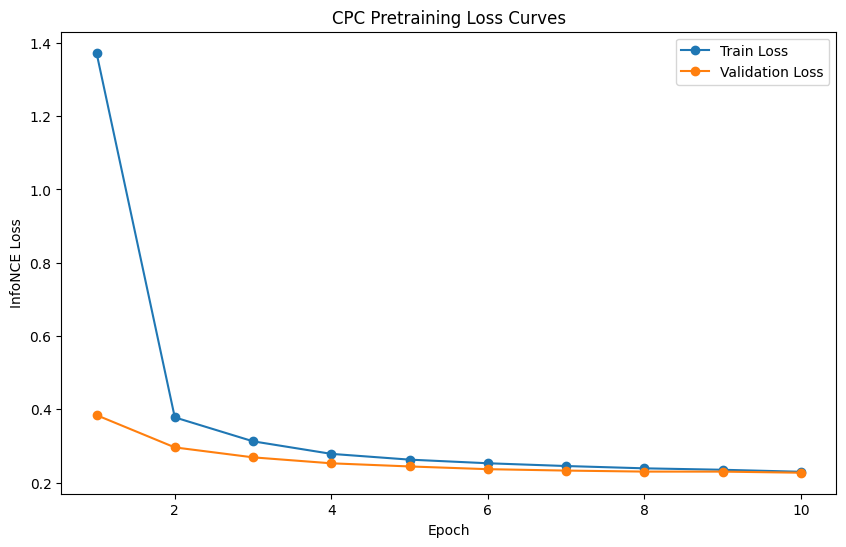

In [55]:
# Hyperparameters for CPC training
num_cpc_epochs = 10
patience = 2  # Number of epochs to wait for improvement on the validation set
best_val_loss = float('inf')
no_improve = 0

# Lists to store losses for plotting
cpc_losses_train = []
cpc_losses_val = []

# Training loop with validation monitoring and early stopping
for epoch in range(num_cpc_epochs):
    cpc_model.train()
    running_loss_train = 0.0
    num_batches_train = len(train_loader)
    
    # Training phase
    for batch_data, _ in tqdm(train_loader, desc=f"CPC Epoch {epoch+1}/{num_cpc_epochs} (Train)", leave=False):
        batch_data = batch_data.to(device)
        optimizer_cpc.zero_grad()
        loss = cpc_model.compute_loss(batch_data)
        loss.backward()
        optimizer_cpc.step()
        running_loss_train += loss.item()
    
    avg_train_loss = running_loss_train / num_batches_train
    cpc_losses_train.append(avg_train_loss)
    
    # Validation phase
    cpc_model.eval()
    running_loss_val = 0.0
    num_batches_val = len(val_loader)
    
    with torch.no_grad():
        for batch_data, _ in tqdm(val_loader, desc=f"CPC Epoch {epoch+1}/{num_cpc_epochs} (Validation)", leave=False):
            batch_data = batch_data.to(device)
            loss_val = cpc_model.compute_loss(batch_data)
            running_loss_val += loss_val.item()
    
    avg_val_loss = running_loss_val / num_batches_val
    cpc_losses_val.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_cpc_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Early stopping: check if validation loss improved significantly
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

# Plotting the loss curves for both training and validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cpc_losses_train)+1), cpc_losses_train, label='Train Loss', marker='o')
plt.plot(range(1, len(cpc_losses_val)+1), cpc_losses_val, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('InfoNCE Loss')
plt.title('CPC Pretraining Loss Curves')
plt.legend()
plt.show()

In [56]:

# For logistic regression and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

# ----------------------------
# Freeze Pretrained CPC Network
# ----------------------------
cpc_model.eval()
for param in cpc_model.parameters():
    param.requires_grad = False

# ----------------------------
# Function to Compute Embeddings
# ----------------------------
def compute_embeddings(model, data_loader):
    """
    Compute a single embedding per patient by processing through the CPC network and averaging
    the context vectors over time.
    """
    embeddings_list = []
    labels_list = []
    with torch.no_grad():
        for batch_data, batch_labels in tqdm(data_loader, desc="Computing Embeddings", leave=False):
            batch_data = batch_data.to(device)
            # Forward pass through the CPC model: returns latent z and context c
            z, c = model(batch_data)  # c shape: (batch, seq_len, model_dim)
            # Aggregate over time (e.g. average pooling) to get a single embedding vector per patient
            embedding = c.mean(dim=1)  # shape: (batch, model_dim)
            embeddings_list.append(embedding.cpu())
            labels_list.append(batch_labels.cpu())
    
    embeddings = torch.cat(embeddings_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    return embeddings, labels

# Compute embeddings for train and test sets
train_embeddings, train_labels = compute_embeddings(cpc_model, train_loader)
test_embeddings, test_labels = compute_embeddings(cpc_model, test_loader)

print("Train Embeddings Shape:", train_embeddings.shape)
print("Test Embeddings Shape:", test_embeddings.shape)


Train Embeddings Shape: torch.Size([3997, 64])
Test Embeddings Shape: torch.Size([3998, 64])


In [57]:
from sklearn.model_selection import GridSearchCV

def train_and_evaluate_logistic_regression(X_train, y_train, X_test, y_test):
    # ----------------------------
    # Train a Logistic Regression (Linear Probe)
    # ----------------------------
    
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'solver': ['lbfgs', 'liblinear'],  # Solvers
        'max_iter': [100, 500, 1000]  # Maximum iterations
    }

    # Create a Logistic Regression model
    base_clf = LogisticRegression(random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=base_clf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Retrieve the best model
    clf = grid_search.best_estimator_
    print(f"Best Hyperparameters: {grid_search.best_params_}")

    # Predict probabilities on the test set
    y_prob = clf.predict_proba(X_test)[:, 1]
    # Predict binary labels (threshold 0.5)
    y_pred = (y_prob >= 0.5).astype(int)

    # ----------------------------
    # Evaluation Metrics
    # ----------------------------
    accuracy = accuracy_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_prob)
    auprc = average_precision_score(y_test, y_prob)

    print(f"Linear Probe Results:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"AUROC: {auroc:.4f}")
    print(f"AUPRC: {auprc:.4f}")

### 3.1 part 2

In [58]:
X_train = train_embeddings.numpy()
y_train = train_labels.numpy().ravel()  # flatten to 1D
X_test = test_embeddings.numpy()
y_test = test_labels.numpy().ravel()

train_and_evaluate_logistic_regression(X_train, y_train, X_test, y_test)

Best Hyperparameters: {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
Linear Probe Results:
Accuracy: 85.87%
AUROC: 0.7850
AUPRC: 0.4052


### 3.2 part 2

In [59]:
# Choose random 100, 500, 1000 data point from training set to train the logistic regression model
def random_sample(X, y, n_samples):
    indices = np.random.choice(len(X), size=n_samples, replace=False)
    return X[indices], y[indices]

X_train_100, y_train_100 = random_sample(X_train, y_train, 100)
X_train_500, y_train_500 = random_sample(X_train, y_train, 500)
X_train_1000, y_train_1000 = random_sample(X_train, y_train, 1000)

print("Training with 100 samples:")
train_and_evaluate_logistic_regression(X_train_100, y_train_100, X_test, y_test)

print("Training with 500 samples:")
train_and_evaluate_logistic_regression(X_train_500, y_train_500, X_test, y_test)

print("Training with 1000 samples:")
train_and_evaluate_logistic_regression(X_train_1000, y_train_1000, X_test, y_test)

Training with 100 samples:
Best Hyperparameters: {'C': 0.01, 'max_iter': 100, 'solver': 'lbfgs'}
Linear Probe Results:
Accuracy: 85.37%
AUROC: 0.6774
AUPRC: 0.2508
Training with 500 samples:
Best Hyperparameters: {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}
Linear Probe Results:
Accuracy: 85.09%
AUROC: 0.7367
AUPRC: 0.3171
Training with 1000 samples:
Best Hyperparameters: {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}
Linear Probe Results:
Accuracy: 85.42%
AUROC: 0.7601
AUPRC: 0.3790


### 3.3

In [2]:
import os

save_folder = 'embeddings'

train_embeddings = np.load(os.path.join(save_folder, 'train_embeddings.npy'))
test_embeddings = np.load(os.path.join(save_folder, 'test_embeddings.npy'))
train_labels = np.load(os.path.join(save_folder, 'train_labels.npy'))
test_labels = np.load(os.path.join(save_folder, 'test_labels.npy'))

train_embeddings.shape, test_embeddings.shape, train_labels.shape, test_labels.shape

((3997, 64), (3998, 64), (3997, 1), (3998, 1))

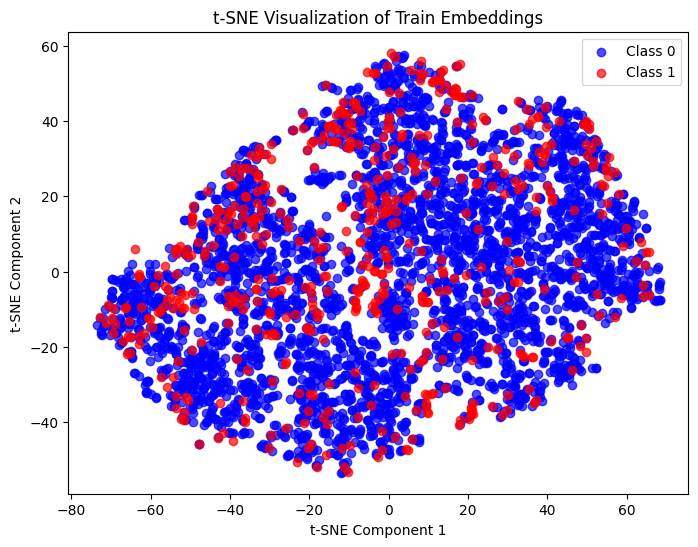

Adjusted Rand Index (ARI): 0.003878155748363426
Normalized Mutual Information (NMI): 0.0010824302093409251


In [3]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Assume train_embeddings is a NumPy array of shape (n_samples, n_features)
# and train_labels is a NumPy array or list containing binary labels (0 or 1).

# Ensure train_labels is a 1D array
train_labels = np.array(train_labels).flatten()

# Step 1: Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(train_embeddings)

# Step 2: Plot the t-SNE results using distinct colors for each binary label
plt.figure(figsize=(8, 6))
# Plot points for class 0
plt.scatter(embeddings_2d[train_labels == 0, 0], embeddings_2d[train_labels == 0, 1],
            color='blue', alpha=0.7, label='Class 0')
# Plot points for class 1
plt.scatter(embeddings_2d[train_labels == 1, 0], embeddings_2d[train_labels == 1, 1],
            color='red', alpha=0.7, label='Class 1')
plt.title('t-SNE Visualization of Train Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

# Step 3: Perform KMeans clustering on the 2D embeddings
n_clusters = len(np.unique(train_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters = kmeans.fit_predict(embeddings_2d)

# Step 4: Compute clustering metrics using the true labels
ari = adjusted_rand_score(train_labels, predicted_clusters)
nmi = normalized_mutual_info_score(train_labels, predicted_clusters)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)


c:\Users\butania1\ETH\ML4H\project1\ML4H_Project1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\butania1\ETH\ML4H\project1\ML4H_Project1\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\butania1\ETH\ML4H\project1\ML4H_Project1\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


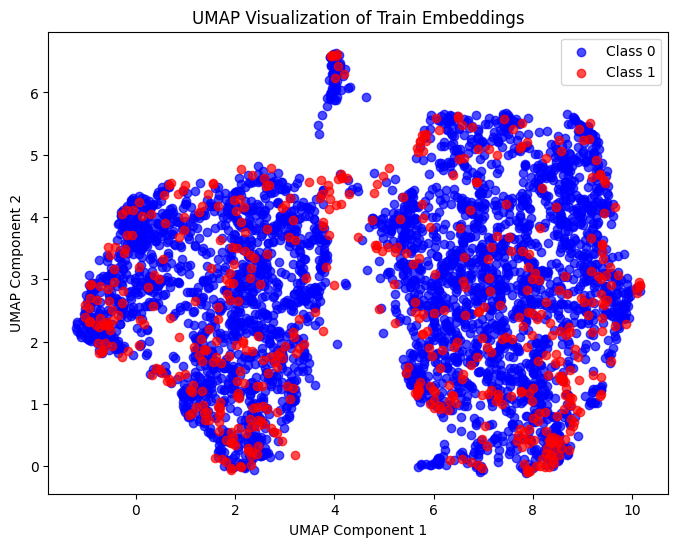

Adjusted Rand Index (ARI): 0.0021737488464217687
Normalized Mutual Information (NMI): 0.00034289240496889015


In [4]:
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Assume train_embeddings is a NumPy array of shape (n_samples, n_features)
# and train_labels is a NumPy array or list containing binary labels (0 or 1).

# Ensure train_labels is a 1D array
train_labels = np.array(train_labels).flatten()

# Step 1: Dimensionality reduction using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_model.fit_transform(train_embeddings)

# Step 2: Plot the UMAP results using distinct colors for each binary label
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[train_labels == 0, 0], embeddings_2d[train_labels == 0, 1],
            color='blue', alpha=0.7, label='Class 0')
plt.scatter(embeddings_2d[train_labels == 1, 0], embeddings_2d[train_labels == 1, 1],
            color='red', alpha=0.7, label='Class 1')
plt.title('UMAP Visualization of Train Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

# Step 3: Perform KMeans clustering on the 2D UMAP embeddings
n_clusters = len(np.unique(train_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters = kmeans.fit_predict(embeddings_2d)

# Step 4: Compute clustering metrics using the true labels
ari = adjusted_rand_score(train_labels, predicted_clusters)
nmi = normalized_mutual_info_score(train_labels, predicted_clusters)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

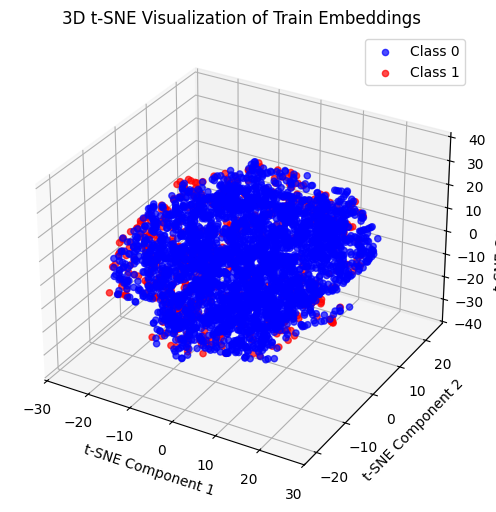

Adjusted Rand Index (ARI): 0.0032001444940253617
Normalized Mutual Information (NMI): 0.0009880015666705478


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plotting

# Assume train_embeddings is a NumPy array of shape (n_samples, n_features)
# and train_labels is a NumPy array or list containing binary labels (0 or 1).

# Ensure train_labels is a 1D array
train_labels = np.array(train_labels).flatten()

# Step 1: Dimensionality reduction using t-SNE for 3D
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(train_embeddings)

# Step 2: Plot the 3D t-SNE results using distinct colors for each binary label
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot points for class 0
ax.scatter(embeddings_3d[train_labels == 0, 0],
           embeddings_3d[train_labels == 0, 1],
           embeddings_3d[train_labels == 0, 2],
           color='blue', alpha=0.7, label='Class 0')

# Plot points for class 1
ax.scatter(embeddings_3d[train_labels == 1, 0],
           embeddings_3d[train_labels == 1, 1],
           embeddings_3d[train_labels == 1, 2],
           color='red', alpha=0.7, label='Class 1')

ax.set_title('3D t-SNE Visualization of Train Embeddings')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.legend()
plt.show()

# Step 3: Perform KMeans clustering on the 3D embeddings
n_clusters = len(np.unique(train_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters = kmeans.fit_predict(embeddings_3d)

# Step 4: Compute clustering metrics using the true labels
ari = adjusted_rand_score(train_labels, predicted_clusters)
nmi = normalized_mutual_info_score(train_labels, predicted_clusters)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

c:\Users\butania1\ETH\ML4H\project1\ML4H_Project1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\butania1\ETH\ML4H\project1\ML4H_Project1\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\butania1\ETH\ML4H\project1\ML4H_Project1\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


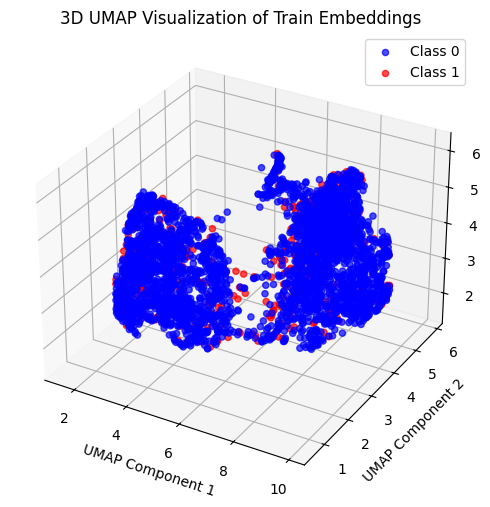

Adjusted Rand Index (ARI): 0.0016194535949286275
Normalized Mutual Information (NMI): 0.0001873918343621429


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

# Assume train_embeddings is a NumPy array of shape (n_samples, n_features)
# and train_labels is a NumPy array or list containing binary labels (0 or 1).

# Ensure train_labels is a 1D array
train_labels = np.array(train_labels).flatten()

# Step 1: Dimensionality reduction using UMAP for 3D
umap_model = umap.UMAP(n_components=3, random_state=42)
embeddings_3d = umap_model.fit_transform(train_embeddings)

# Step 2: Plot the 3D UMAP results using distinct colors for each binary label
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot points for class 0
ax.scatter(embeddings_3d[train_labels == 0, 0],
           embeddings_3d[train_labels == 0, 1],
           embeddings_3d[train_labels == 0, 2],
           color='blue', alpha=0.7, label='Class 0')

# Plot points for class 1
ax.scatter(embeddings_3d[train_labels == 1, 0],
           embeddings_3d[train_labels == 1, 1],
           embeddings_3d[train_labels == 1, 2],
           color='red', alpha=0.7, label='Class 1')

ax.set_title('3D UMAP Visualization of Train Embeddings')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
ax.legend()
plt.show()

# Step 3: Perform KMeans clustering on the 3D embeddings
n_clusters = len(np.unique(train_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters = kmeans.fit_predict(embeddings_3d)

# Step 4: Compute clustering metrics using the true labels
ari = adjusted_rand_score(train_labels, predicted_clusters)
nmi = normalized_mutual_info_score(train_labels, predicted_clusters)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)
